In [ ]:
# Requirements
!pip install pandas torch transformers scikit-learn tensorflow==2.12.0

In [ ]:
import os, torch, numpy as np, pandas as pd, re
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5EncoderModel
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:
# ========== CONFIG ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 512
EPOCHS = 3
LR = 2e-5

CSV_PATH = "/content/drive/MyDrive/sentiment5/df_expanded_latest.csv"
SAVE_PATH = "/content/drive/MyDrive/final_models_saved/ProposedVLM/proposed_model_final_3.pt"

In [ ]:
# ========== TOKENIZER & ENCODER ==========
tokenizer = T5Tokenizer.from_pretrained("Anshul99/ALM_BLM_Narratives_Stance_using")
encoder = T5EncoderModel.from_pretrained("Anshul99/ALM_BLM_Narratives_Stance_using").to(DEVICE)
encoder.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

T5EncoderModel(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
              (wo):

In [ ]:
# ========== LOAD DATA ==========
df = pd.read_csv(CSV_PATH)
df = df[df['label'].isin([0, 1])]
df = df.dropna(subset=['text', 'frame_embedding'])
df = df[df['frame_embedding'].apply(lambda x: isinstance(x, str))]

In [ ]:
display(df.head())

,text,word,label,frame_embedding,frame_label,ground_truth,input_text,target_text
0,So the night before Thursday evening at around...,statistics,0,"[0.0, 0.0, 0.0002427995204925537, 0.1918396502...",1,0,classify sentiment: So the night before Thursd...,negative
1,But the more African Americans that I speak to...,voices,0,"[0.0, 0.0, 0.0005758404731750488, 0.2088011056...",0,0,classify sentiment: But the more African Ameri...,negative
2,A riot is a riot no matter who precipitates it...,people,0,"[0.0, 0.0, 0.002689540386199951, 0.20908959209...",0,0,classify sentiment: A riot is a riot no matter...,negative
3,"Um, I think that the, the places where I found...",leadership,1,"[0.0, 0.0, 0.0, 0.19171279668807983, 0.0, 1.03...",1,1,"classify sentiment: Um, I think that the, the ...",positive
4,"When I think about racism in America, I imagin...",branches,0,"[0.0, 0.0, 0.005467772483825684, 0.20671126246...",0,0,classify sentiment: When I think about racism ...,negative


In [ ]:
unique_df = df.drop_duplicates(keep='first')
print(len(df),len(unique_df))

1735218 1376359


In [ ]:
# ========== DATASET ==========
import ast
class MultimodalTextFrameDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Text embedding from MaskedABSA encoder
        enc = tokenizer(row['text'], return_tensors='pt', max_length=64, padding='max_length', truncation=True).to(DEVICE)
        with torch.no_grad():
            text_emb = encoder(**enc).last_hidden_state.mean(dim=1).squeeze().cpu()

        try:
            frame = np.array(ast.literal_eval(row['frame_embedding']))
            frame_emb = torch.tensor(frame, dtype=torch.float32)
        except:
            frame_emb = torch.zeros(256, dtype=torch.float32)

        label = int(row['label'])
        return {
            'text_embedding': text_emb,
            'frame_embedding': frame_emb,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# ========== SPLIT ==========
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_set = MultimodalTextFrameDataset(train_df)
val_set = MultimodalTextFrameDataset(val_df)
test_set = MultimodalTextFrameDataset(test_df)

train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
val_loader = DataLoader(val_set, batch_size=512)
test_loader = DataLoader(test_set, batch_size=512)

In [ ]:
print(len(train_set), len(val_set), len(test_set))
print(len(train_loader), len(val_loader), len(test_loader))

1041130 347044 347044
2034 678 678


In [ ]:
# from tensorflow.keras.models import load_model
temporal_model_path = "/content/drive/MyDrive/sentiment/new_csv/models/for_RAVDESS.h5"
lstm_keras_model = load_model(temporal_model_path)

In [ ]:
# ========== MODEL ==========
class SimpleFusionModel(nn.Module):
    def __init__(self, text_dim=1024, frame_dim=256, hidden_dim=256):
        super().__init__()
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.frame_proj = nn.Linear(frame_dim, hidden_dim)

        # Temporal Model (from pretrained)
        self.lstm1 = nn.LSTM(input_size=hidden_dim * 2, hidden_size=512, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)

        # Classifier on top of LSTM output
        self.classifier = nn.Linear(256, 2)

    def forward(self, text_embed, frame_embed):
        t = self.text_proj(text_embed)  # (B, H)
        f = self.frame_proj(frame_embed)  # (B, H)
        x = torch.cat([t, f], dim=1)  # (B, H*2)
        x = x.unsqueeze(1)  # (B, 1, H*2) – adding sequence dimension

        out1, _ = self.lstm1(x)
        out2, _ = self.lstm2(out1)
        out = out2[:, -1, :]  # (B, 256) – take last hidden state

        return self.classifier(out)  # (B, 2)

In [ ]:
m = SimpleFusionModel()
print(m)

SimpleFusionModel(
  (text_proj): Linear(in_features=1024, out_features=256, bias=True)
  (frame_proj): Linear(in_features=256, out_features=256, bias=True)
  (lstm1): LSTM(512, 512, batch_first=True)
  (lstm2): LSTM(512, 256, batch_first=True)
  (classifier): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
def convert_lstm_weights(keras_weights):
    W, U, b = keras_weights
    return torch.from_numpy(W.T), torch.from_numpy(U.T), torch.from_numpy(b)

def init_lstm_weights(pytorch_model, keras_model):
    lstm1_weights = keras_model.layers[1].get_weights()
    lstm2_weights = keras_model.layers[2].get_weights()

    W_ih1, W_hh1, b1 = convert_lstm_weights(lstm1_weights)
    W_ih2, W_hh2, b2 = convert_lstm_weights(lstm2_weights)

    pytorch_model.lstm1.weight_ih_l0.data.copy_(W_ih1)
    pytorch_model.lstm1.weight_hh_l0.data.copy_(W_hh1)
    pytorch_model.lstm1.bias_ih_l0.data.copy_(b1)
    pytorch_model.lstm1.bias_hh_l0.data.zero_()

    pytorch_model.lstm2.weight_ih_l0.data.copy_(W_ih2)
    pytorch_model.lstm2.weight_hh_l0.data.copy_(W_hh2)
    pytorch_model.lstm2.bias_ih_l0.data.copy_(b2)
    pytorch_model.lstm2.bias_hh_l0.data.zero_()

In [ ]:
# ========== TRAINING ==========
def get_latest_checkpoint(save_dir):
    """Return the latest checkpoint path and epoch number from the directory."""
    if not os.path.exists(save_dir):
        return None, 0
    checkpoints = [f for f in os.listdir(save_dir) if f.startswith("proposed_model_epoch_")]
    if not checkpoints:
        return None, 0
    epochs = [int(re.findall(r'\d+', f)[0]) for f in checkpoints]
    latest_epoch = max(epochs)
    latest_ckpt = os.path.join(save_dir, f"proposed_model_epoch_{latest_epoch}.pt")
    return latest_ckpt, latest_epoch

def evaluate(model, loader, return_preds=False):
    model.eval()
    preds, probs, targets = [], [], []
    with torch.no_grad():
        for batch in loader:
            text = batch["text_embedding"].to(DEVICE)
            frame = batch["frame_embedding"].to(DEVICE)
            label = batch["label"].to(DEVICE)
            logits = model(text, frame)
            prob = torch.softmax(logits, dim=1)
            pred = torch.argmax(prob, dim=1)
            preds.extend(pred.cpu().numpy())
            probs.extend(prob[:, 1].cpu().numpy())
            targets.extend(label.cpu().numpy())
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)
    auc = roc_auc_score(targets, probs)
    return (acc, f1, auc, preds, targets) if return_preds else (acc, f1, auc)

def train(model, train_loader, val_loader, epochs, save_dir="/content/drive/MyDrive/final_models_saved/ProposedVLM/checkpoints"):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path, start_epoch = get_latest_checkpoint(save_dir)

    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()

    # 🔁 Load from checkpoint if exists
    if checkpoint_path:
        model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
        print(f"🔁 Resumed from checkpoint: {checkpoint_path} | Starting at epoch {start_epoch + 1}")
    else:
        print("🚀 Starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            text = batch['text_embedding'].to(DEVICE)
            frame = batch['frame_embedding'].to(DEVICE)
            label = batch['label'].to(DEVICE)

            optimizer.zero_grad()
            logits = model(text, frame)
            loss = loss_fn(logits, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # print("Loss computed")
        # 💾 Save checkpoint
        ckpt_path = os.path.join(save_dir, f"proposed_model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), ckpt_path)
        print(f"💾 Checkpoint saved at: {ckpt_path}")

        # Validation Metrics
        # acc, f1, auc = evaluate(model, val_loader)
        # print(f"✅ Epoch {epoch+1}: Val Loss={total_loss:.2f}, Val Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

In [ ]:
# ========== RUN ==========
model = SimpleFusionModel()
init_lstm_weights(model, lstm_keras_model)

In [ ]:
train(model, train_loader, val_loader, EPOCHS)

🔁 Resumed from checkpoint: /content/drive/MyDrive/final_models_saved/ProposedVLM/checkpoints/proposed_model_epoch_1.pt | Starting at epoch 2


Epoch 2/3: 100%|██████████| 2034/2034 [7:47:45<00:00, 13.80s/it]


💾 Checkpoint saved at: /content/drive/MyDrive/final_models_saved/ProposedVLM/checkpoints/proposed_model_epoch_2.pt


Epoch 3/3: 100%|██████████| 2034/2034 [7:45:54<00:00, 13.74s/it]

💾 Checkpoint saved at: /content/drive/MyDrive/final_models_saved/ProposedVLM/checkpoints/proposed_model_epoch_3.pt


In [ ]:
# Requirements
!pip install pandas torch transformers scikit-learn tensorflow==2.12.0

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import torch, os, re
import torch.nn as nn
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tensorflow.keras.models import load_model
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 5
SEQ_LEN = 10
LR = 2e-5

# Paths
SUBTITLE_PATH = "/subtitles"
ANNOTATION_SUBTITLES_PATH = "/annotation/subtitles"
FRAME_LABEL_CSV = "/emotion_frame_dataset.csv"
X_FEATURES_PATH = "/X_features_balanced.npy"
Y_LABELS_PATH = "/y_labels_balanced.npy"
X_VIDEONAMES_PATH = "/X_videonames_balanced.npy"
CSV_PATH = "/df_expanded.csv"
LSTM_WEIGHTS_PATH = "/models/for_RAVDESS.h5"

In [ ]:
# Load features
X = np.load(X_FEATURES_PATH)
y = np.load(Y_LABELS_PATH)
X_videonames = np.load(X_VIDEONAMES_PATH, allow_pickle=True)
df_expanded = pd.read_csv(CSV_PATH)

In [ ]:
video_to_feat = {video_id: feat for video_id, feat in zip(X_videonames, X)}
df_expanded["vision_feat"] = df_expanded["video_id"].map(video_to_feat)
df_expanded = df_expanded.dropna(subset=["vision_feat"]).reset_index(drop=True)

In [ ]:
# Split
train_df, temp_df, train_idx, temp_idx = train_test_split(df_expanded, np.arange(len(df_expanded)), test_size=0.4, stratify=df_expanded['label'], random_state=42)
val_df, test_df, val_idx, test_idx = train_test_split(temp_df, temp_idx, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
# LSTM Weights
lstm_keras_model = tf.keras.models.load_model(LSTM_WEIGHTS_PATH)
lstm1_weights = lstm_keras_model.layers[1].get_weights()
lstm2_weights = lstm_keras_model.layers[2].get_weights()

In [ ]:
# Tokenizer
tokenizer = T5Tokenizer.from_pretrained("Anshul99/ALM_BLM_Narratives_Stance_using")

# Dataset
class MultimodalDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        with open(row['subtitle_path'], "r", encoding="utf-8") as f:
            subtitle_text = f.read()
        encoded = self.tokenizer(subtitle_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

        vision_tensor = torch.tensor(row['vision_feat'], dtype=torch.float32)  # 👈 Now directly from DataFrame
        return {
            "input_ids": encoded['input_ids'].squeeze(0),
            "attention_mask": encoded['attention_mask'].squeeze(0),
            "vision_seq": vision_tensor,
            "label": torch.tensor(row['label'], dtype=torch.long)
        }

train_set = MultimodalDataset(train_df, tokenizer)
val_set = MultimodalDataset(val_df, tokenizer)
test_set = MultimodalDataset(test_df, tokenizer)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
print(len(train_set), len(val_set), len(test_set))
print(len(train_loader), len(val_loader), len(test_loader))

131568 43856 43857
4112 1371 1371


In [ ]:
# ========== MODEL ==========
class FusedModel(nn.Module):
    def __init__(self, t5_model, vision_dim=32, fused_dim=512, seq_len=10):
        super(FusedModel, self).__init__()
        self.t5_encoder = t5_model.encoder
        self.t5_proj = nn.Linear(1024, fused_dim // 2)
        self.vision_proj = nn.Linear(256, fused_dim // 2)
        self.dropout = nn.Dropout(0.3)
        self.seq_len = seq_len
        self.lstm1 = nn.LSTM(fused_dim, 512, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, batch_first=True)
        self.classifier = nn.Linear(256, 2)

    def forward(self, input_ids, attention_mask, vision_seq):
        text_embed = self.t5_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_embed = self.t5_proj(text_embed)
        vision_embed = self.vision_proj(vision_seq)
        fused = self.dropout(torch.cat([text_embed, vision_embed], dim=1))
        fused_seq = fused.unsqueeze(1).repeat(1, self.seq_len, 1)
        lstm_out, _ = self.lstm1(fused_seq)
        lstm_out2, _ = self.lstm2(lstm_out)
        logits = self.classifier(lstm_out2[:, -1, :])
        return logits

In [ ]:
def convert_lstm1_weights(keras_weights):
    W, U, b = keras_weights
    return torch.from_numpy(W.T), torch.from_numpy(U.T), torch.from_numpy(b)

def convert_lstm2_weights(keras_weights):
    W, U, b = keras_weights
    return torch.from_numpy(W.T), torch.from_numpy(U.T), torch.from_numpy(b)

def initialize_lstm_with_keras(fused_model, lstm1_weights, lstm2_weights):
    W_ih1, W_hh1, b1 = convert_lstm1_weights(lstm1_weights)
    W_ih2, W_hh2, b2 = convert_lstm2_weights(lstm2_weights)
    fused_model.lstm1.weight_ih_l0.data.copy_(W_ih1)
    fused_model.lstm1.weight_hh_l0.data.copy_(W_hh1)
    fused_model.lstm1.bias_ih_l0.data.copy_(b1)
    fused_model.lstm1.bias_hh_l0.data.zero_()
    fused_model.lstm2.weight_ih_l0.data.copy_(W_ih2)
    fused_model.lstm2.weight_hh_l0.data.copy_(W_hh2)
    fused_model.lstm2.bias_ih_l0.data.copy_(b2)
    fused_model.lstm2.bias_hh_l0.data.zero_()

def evaluate(model, loader, return_preds=False):
    model.eval()
    preds, probs, targets = [], [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            vision = batch["vision_seq"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            logits = model(ids, mask, vision)
            prob = torch.softmax(logits, dim=1)
            pred = torch.argmax(prob, dim=1)
            preds.extend(pred.cpu().numpy())
            probs.extend(prob[:, 1].cpu().numpy())
            targets.extend(labels.cpu().numpy())
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)
    auc = roc_auc_score(targets, probs)
    return (acc, f1, auc, preds, targets) if return_preds else (acc, f1, auc)

def train(model, train_loader, val_loader, epochs):
    model.to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        batch_idx = 0
        n = len(train_loader)
        for batch in train_loader:
            batch_idx += 1
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            vision = batch["vision_seq"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            optim.zero_grad()
            logits = model(ids, mask, vision)
            loss = loss_fn(logits, labels)
            loss.backward()
            optim.step()
            total_loss += loss.item()
            print(f"Epoch {epoch+1}: Batch {batch_idx}/{n}")
        acc, f1, auc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}: Loss={total_loss:.2f} | Val Acc={acc:.4f} | F1={f1:.4f} | AUC={auc:.4f}")

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("Anshul99/ALM_BLM_Narratives_Stance_using")
fused_model = FusedModel(model)
initialize_lstm_with_keras(fused_model, lstm1_weights, lstm2_weights)
train(fused_model, train_loader, val_loader, EPOCHS)

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Epoch 4: Batch 3227/4112
Epoch 4: Batch 3228/4112
Epoch 4: Batch 3229/4112
Epoch 4: Batch 3230/4112
Epoch 4: Batch 3231/4112
Epoch 4: Batch 3232/4112
Epoch 4: Batch 3233/4112
Epoch 4: Batch 3234/4112
Epoch 4: Batch 3235/4112
Epoch 4: Batch 3236/4112
Epoch 4: Batch 3237/4112
Epoch 4: Batch 3238/4112
Epoch 4: Batch 3239/4112
Epoch 4: Batch 3240/4112
Epoch 4: Batch 3241/4112
Epoch 4: Batch 3242/4112
Epoch 4: Batch 3243/4112
Epoch 4: Batch 3244/4112
Epoch 4: Batch 3245/4112
Epoch 4: Batch 3246/4112
Epoch 4: Batch 3247/4112
Epoch 4: Batch 3248/4112
Epoch 4: Batch 3249/4112
Epoch 4: Batch 3250/4112
Epoch 4: Batch 3251/4112
Epoch 4: Batch 3252/4112
Epoch 4: Batch 3253/4112
Epoch 4: Batch 3254/4112
Epoch 4: Batch 3255/4112
Epoch 4: Batch 3256/4112
Epoch 4: Batch 3257/4112
Epoch 4: Batch 3258/4112
Epoch 4: Batch 3259/4112
Epoch 4: Batch 3260/4112
Epoch 4: Batch 3261/4112
Epoch 4: Batch 3262/4112
Epoch 4: Batch 3263/4112
Epoch 4: Batch 3264/4112


Final Test: Accuracy=0.8574, F1=0.8645, AUC=0.9515


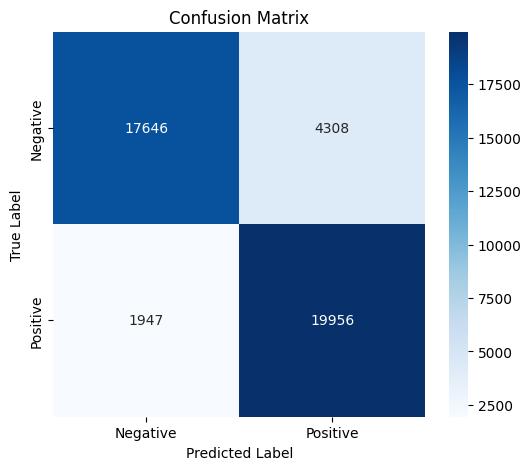

In [ ]:
acc, f1, auc, preds, targets = evaluate(fused_model, test_loader, return_preds=True)
print(f"\nFinal Test: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

conf_mat = confusion_matrix(targets, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/final_models_saved/ProposedVLM/proposed_model_final.pt"
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
torch.save(fused_model.state_dict(), SAVE_PATH)
print(f"Model saved at: {SAVE_PATH}")

Model saved at: /content/drive/MyDrive/final_models_saved/ProposedVLM/proposed_model_final.pt


In [ ]:
# ========== SAVE ==========
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")

✅ Model saved at: /content/drive/MyDrive/final_models_saved/ProposedVLM/proposed_model_final_3.pt


In [ ]:
acc, f1, auc, preds, targets = evaluate(model, test_loader, return_preds=True)
print(f"\nFinal Test: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")


Final Test: Accuracy=0.7231, F1=0.7047, AUC=0.8073


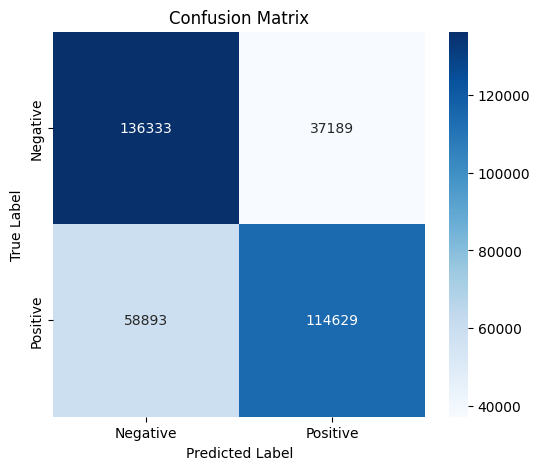

In [ ]:
# ========== CONFUSION MATRIX ==========
# acc, f1, auc, preds, targets = evaluate(model, test_loader, return_preds=True)
# print(f"\nFinal Test: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

conf_mat = confusion_matrix(targets, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Extras

In [ ]:
# # Model
# class FusedModel(nn.Module):
#     def __init__(self, t5_model, vision_dim=32, fused_dim=512, seq_len=10):
#         super(FusedModel, self).__init__()
#         self.t5_encoder = t5_model.encoder
#         self.t5_proj = nn.Linear(1024, fused_dim // 2)
#         self.vision_proj = nn.Linear(256, fused_dim // 2)
#         self.dropout = nn.Dropout(0.3)
#         self.seq_len = seq_len
#         self.lstm1 = nn.LSTM(fused_dim, 512, batch_first=True)
#         self.lstm2 = nn.LSTM(512, 256, batch_first=True)
#         self.classifier = nn.Linear(256, 2)

#     def forward(self, input_ids, attention_mask, vision_seq):
#         text_embed = self.t5_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
#         text_embed = self.t5_proj(text_embed)
#         vision_embed = self.vision_proj(vision_seq)
#         fused = self.dropout(torch.cat([text_embed, vision_embed], dim=1))
#         fused_seq = fused.unsqueeze(1).repeat(1, self.seq_len, 1)
#         lstm_out, _ = self.lstm1(fused_seq)
#         lstm_out2, _ = self.lstm2(lstm_out)
#         logits = self.classifier(lstm_out2[:, -1, :])
#         return logits

In [ ]:
# # Dataset
# class MultimodalDataset(Dataset):
#     def __init__(self, df, vision_features, tokenizer):
#         self.df = df.reset_index(drop=True)
#         self.vision_features = vision_features
#         self.tokenizer = tokenizer

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         encoded = self.tokenizer(row['input_text'], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
#         return {
#             "input_ids": encoded['input_ids'].squeeze(0),
#             "attention_mask": encoded['attention_mask'].squeeze(0),
#             "vision_seq": torch.tensor(self.vision_features[idx], dtype=torch.float32),
#             "label": torch.tensor(row['label'], dtype=torch.long)
#         }

In [ ]:
# train_set = MultimodalDataset(train_df, X[train_idx], tokenizer)
# val_set = MultimodalDataset(val_df, X[val_idx], tokenizer)
# test_set = MultimodalDataset(test_df, X[test_idx], tokenizer)

# train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
# test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)